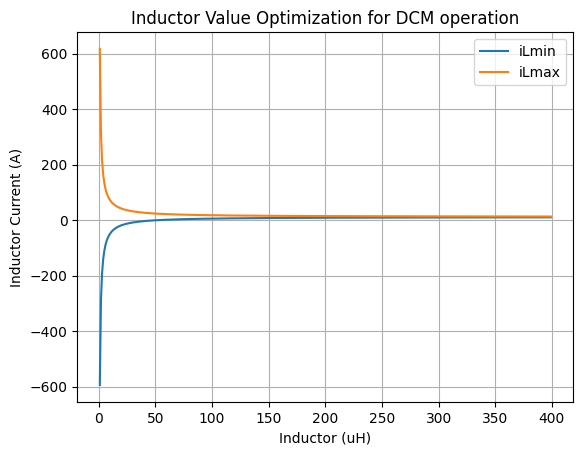

In [3]:
%run iL_optimise.py

In [4]:
%run iL_optimise_plotly.py

In [12]:
import io
import control as ct
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib import pyplot as plt
pio.renderers.default = "vscode"

s = ct.TransferFunction.s

def plot_response(d: float, vin: float, inductor: float, capacitor: float, resistor: float, mode: str) -> tuple:
    global yg_ss, yd_ss, sys_g, sys_d, tg, td, yg, yd
    
    response_functions = {
        'Buck': buck_response_vg,
        'Boost': boost_response_vg,
        'BuckBoost': buck_boost_response_vg
    }

    # if mode == 'Buck':
    #     t, y, sys = buck_response(d, vin, inductor, capacitor, resistor)
    #     y_ss = y[-1]
    # elif mode == 'Boost':
    #     t, y, sys = boost_response(d, vin, inductor, capacitor, resistor)
    #     y_ss = y[-1]
    # elif mode == 'BuckBoost':
    #     t, y, sys = buck_boost_response(d, vin, inductor, capacitor, resistor)
    #     y_ss = y[-1]
    # else:
    #     return tuple()

    if mode in response_functions:
        tg, yg, sys_g, td, yd, sys_d = response_functions[mode](d, vin, inductor, capacitor, resistor)
        yg_ss = yg[-1]
        yd_ss = yd[-1]

    # fig, ax = plt.subplots(dpi=200)
    # ax.plot(t, y, label='Transient Response')  # Plot steady-state response
    # ax.plot(t, [y_ss] * len(t), label='Steady State Value')
    # ax.set_xlabel('Time(sec)')
    # ax.set_ylabel('Response')
    # ax.set_title(f'Transient Response: Mode-{mode}, Vin-{vin}, D-{d}')
    # ax.text(t[-1], y_ss, f'Steady State Value: {y_ss:.2f}', ha='right', va='bottom')
    # ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    # ax.grid()
    # ax.legend()
    # buf = io.BytesIO()
    # plt.savefig(buf, format='png', dpi=300)
    # plt.close(fig)
    # return buf.getvalue(), str(sys)

    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=tg, y=yg, mode='lines', name='Transient Response Vg(s)'))
    fig1.add_trace(go.Scatter(x=tg, y=[yg_ss] * len(tg), mode='lines', name='Steady State Value'))
    fig1.update_layout(
        title=f'Line-to-Output Transient Response: Mode-{mode}, Vin-{vin}, D-{d}',
        xaxis=dict(
            exponentformat='e',
            tickformat='.0e',
            showexponent='all',
        ),
        xaxis_title='Time(sec)',
        yaxis_title='Response',
        height=600,
        width=720
    )
    fig1.add_annotation(
        x=tg[-1],
        y=yg_ss,
        text=f'Steady State Value: {yg_ss:.2f}',
        showarrow=True,
        arrowhead=1,
        ax=-40,
        ay=-40
    )

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=td, y=yd, mode='lines', name='Transient Response Vd(s)'))
    fig2.add_trace(go.Scatter(x=td, y=[yd_ss] * len(td), mode='lines', name='Steady State Value'))
    fig2.update_layout(
        title=f'Control-to-Output Transient Response: Mode-{mode}, Vin-{vin}, D-{d}',
        xaxis=dict(
            exponentformat='e',
            tickformat='.0e',
            showexponent='all',
        ),
        xaxis_title='Time(sec)',
        yaxis_title='Response',
        height=600,
        width=720
    )
    fig2.add_annotation(
        x=td[-1],
        y=yd_ss,
        text=f'Steady State Value: {yd_ss:.2f}',
        showarrow=True,
        arrowhead=1,
        ax=-40,
        ay=-40
    )

    return fig1, fig2

def buck_response_vg(d: float, vin: float, inductor: float, capacitor: float, resistor: float) -> tuple:
    """
    Buck Converter Line-to-Output transfer function response.
    :param d: duty cycle.
    :param vin: input voltage of converter
    :param inductor: inductor value of converter
    :param capacitor: capacitor value of converter
    :param resistor: output resistor value
    :return: list of time vector and response of the system
    """

    num_vg = np.array([(d*vin)/(inductor*capacitor)])
    den_vg = np.array([1, 1/(resistor*capacitor), 1/(inductor*capacitor)])
    sys_g = ct.tf(num_vg, den_vg)
    # print('H(s) = ', sys)
    t_g, y_g = ct.step_response(sys_g)
    t_d, y_d, sys_d = buck_response_vd(d, vin, inductor, capacitor, resistor)
    return t_g, y_g, sys_g, t_d, y_d, sys_d


def boost_response_vg(d: float, vin: float, inductor: float, capacitor: float, resistor: float) -> tuple:
    """
    Boost Converter Line-to-Output transfer function response.
    :param d: duty cycle.
    :param vin: input voltage of converter
    :param inductor: inductor value of converter
    :param capacitor: capacitor value of converter
    :param resistor: output resistor value
    :return: list of time vector and response of the system
    """

    num_vg = np.array([((1-d)*vin)/(inductor*capacitor)])
    den_vg = np.array([1, 1/(resistor*capacitor), ((1-d)**2)/(inductor*capacitor)])
    sys_g = ct.tf(num_vg, den_vg)
    # print('H(s) = ', sys)
    t_g, y_g = ct.step_response(sys_g)
    t_d, y_d, sys_d = boost_response_vd(d, vin, inductor, capacitor, resistor)
    return t_g, y_g, sys_g, t_d, y_d, sys_d


def buck_boost_response_vg(d: float, vin: float, inductor: float, capacitor: float, resistor: float) -> tuple:
    """
    Buck Boost Converter Line-to-Output transfer function response.
    :param d: duty cycle.
    :param vin: input voltage of converter
    :param inductor: inductor value of converter
    :param capacitor: capacitor value of converter
    :param resistor: output resistor value
    :return: list of time vector and response of the system
    """

    num_vg = np.array([-(((1-d)*d)*vin)/(inductor*capacitor)])
    den_vg = np.array([1, 1/(resistor*capacitor), ((1-d)**2)/(inductor*capacitor)])
    sys_g = ct.tf(num_vg, den_vg)
    # print('H(s) = ', sys)
    t_g, y_g = ct.step_response(sys_g)
    t_d, y_d, sys_d = buck_boost_response_vd(d, vin, inductor, capacitor, resistor)
    return t_g, y_g, sys_g, t_d, y_d, sys_d


def buck_response_vd(d: float, vin: float, inductor: float, capacitor: float, resistor: float) -> tuple:
    """
    Buck Converter Control-to-Output transfer function response.
    :param d: duty cycle.
    :param vin: input voltage of converter
    :param inductor: inductor value of converter
    :param capacitor: capacitor value of converter
    :param resistor: output resistor value
    :return: list of time vector and response of the system
    """

    num_vd = np.array([(vin)/(d*inductor*capacitor)])
    den_vd = np.array([1, 1/(resistor*capacitor), 1/(inductor*capacitor)])
    sys_d = ct.tf(num_vd, den_vd)
    # print('H(s) = ', sys)
    t_d, y_d = ct.step_response(sys_d)
    return t_d, y_d, sys_d


def boost_response_vd(d: float, vin: float, inductor: float, capacitor: float, resistor: float) -> tuple:
    """
    Boost Converter Control-to-Output transfer function response.
    :param d: duty cycle.
    :param vin: input voltage of converter
    :param inductor: inductor value of converter
    :param capacitor: capacitor value of converter
    :param resistor: output resistor value
    :return: list of time vector and response of the system
    """

    num_vd = np.array([-vin/((1-d)*resistor*capacitor), vin/(inductor*capacitor)])
    den_vd = np.array([1, 1/(resistor*capacitor), ((1-d)**2)/(inductor*capacitor)])
    sys_d = ct.tf(num_vd, den_vd)
    # print('H(s) = ', sys)
    t_d, y_d = ct.step_response(sys_d)
    return t_d, y_d, sys_d


def buck_boost_response_vd(d: float, vin: float, inductor: float, capacitor: float, resistor: float) -> tuple:
    """
    Buck Boost Converter Control-to-Output transfer function response.
    :param d: duty cycle.
    :param vin: input voltage of converter
    :param inductor: inductor value of converter
    :param capacitor: capacitor value of converter
    :param resistor: output resistor value
    :return: list of time vector and response of the system
    """

    num_vd = np.array([vin/((1-d)*resistor*capacitor), -(vin*(1-d))/(d*inductor*capacitor)])
    den_vd = np.array([1, 1/(resistor*capacitor), ((1-d)**2)/(inductor*capacitor)])
    sys_d = ct.tf(num_vd, den_vd)
    # print('H(s) = ', sys)

    t_d, y_d = ct.step_response(sys_d)
    return t_d, y_d, sys_d


In [13]:
fig1, fig2 = plot_response(0.75, 12, 200e-6, 100e-6, 10, 'Boost')
fig1.show()
fig2.show()

In [2]:
s = ct.TransferFunction.s
d, inductor, capacitor, resistor, vin = 0.7, 220e-6, 100e-6, 10, 12

H = (-vin/((1-d)*d))*(1-s*((d*inductor)/((1-d)*resistor)))/((s**2)*(inductor*capacitor)/(1-d)*2 + s*(1/(resistor*capacitor)) + 1)
t, y = ct.step_response(H)
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y, mode='lines', name='Transient Response'))
fig.update_layout(
    title=f'Step Response: Buck-Boost Converter, Vin-{vin}, D-{d}',
    xaxis_title='Time(sec)',
    yaxis_title='Response',
    height=600,
    width=720
)
fig.show()

In [1]:
!pwd

/home/ml-brain-dev/workspace/Electrical_Engg/converter-specs-calc-site
